# Отток клиентов

# ОГЛАВЛЕНИЕ

1. Постановка задачи
2. Подготовка данных
        2.1 Описание данных
        2.2  Обработка данных
3. Исследование баланса классов
4. Создание моделей без учета дисбаланса
        4.1  Логистическая регрессия.
        4.2  Решающее дерево
        4.3  Случайный лес
5. Создание моделей c учетом дисбаланса
        5.1  Взвешивание классов
            5.1.1  Логистическая регрессия
            5.1.2  Решающее дерево
            5.1.3  Случайный лес
        5.2  Увеличение выборки
            5.2.1  Логистическая регрессия
            5.2.2  Решающее дерево
            5.2.3  Случайный лес
        5.3  Уменьшение выборки
            5.3.1  Логистическая регрессия
            5.3.2  Решающее дерево
            5.3.3  Случайный лес
6. Тестирование модели

## 1. Постановка задачи

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**Признаки**:
- *RowNumber* — индекс строки в данных
- *CustomerId* — уникальный идентификатор клиента
- *Surname* — фамилия
- *CreditScore* — кредитный рейтинг
- *Geography* — страна проживания
- *Gender* — пол
- *Age* — возраст
- *Tenure* — количество недвижимости у клиента
- *Balance* — баланс на счёте
- *NumOfProducts* — количество продуктов банка, используемых клиентом
- *HasCrCard* — наличие кредитной карты
- *IsActiveMember* — активность клиента
- *EstimatedSalary* — предполагаемая зарплата

**Целевой признак**
- *Exited* — факт ухода клиента

**Цель проекта:**
***Спрогнозировать уйдет ли клиент и добиться при этом значения F1-меры не менее 0,59.***

Порядок выполнения проекта:
1. Загрузка и подготовка данных.
2. Обучение модели без учета дисбаланса классов.
3. Обучение модели с учетом дисбаланса классов.
4. Финальное тестирование.

## 2. Подготовка данных

### 2.1 Описание данных

In [1]:
import pandas as pd
from IPython.display import display #импортируем метод дисплей для красивого вывода таблиц (не применяя print)
pd.set_option('display.max_columns', None) #реализуем возможность вывода всех столбцов на экран
pd.set_option('display.float_format', '{:.3f}'.format) #выаодим значения float до 3 знаков после запятой
from sklearn.tree import DecisionTreeClassifier #решающее дерево
from sklearn.model_selection import train_test_split # деление на 2 выборки
from sklearn.ensemble import RandomForestClassifier # случайный лес
from sklearn.linear_model import LogisticRegression # логистическая регрессия
from sklearn.metrics import accuracy_score # проверка качества
from sklearn.metrics import recall_score # полнота
from sklearn.metrics import precision_score # точность
from sklearn.preprocessing import StandardScaler # для масштабирования количественных признаков
from sklearn.preprocessing import OrdinalEncoder # порядковое кодирование
from sklearn.metrics import f1_score # F1-мера
from sklearn.metrics import roc_curve # для построения кривой RoC
from sklearn.metrics import roc_auc_score # площадь под кривой AUC-ROC
from sklearn.metrics import confusion_matrix # матрица ошибок
from sklearn.utils import shuffle # для перемешивания данных
from sklearn.model_selection import GridSearchCV # для поиска оптимальных параметров
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Выведем основные данные, описывающие датасет.

In [3]:
df = pd.read_csv('Churn.csv', sep=',')
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.000,0.000,1,1,1,101348.880,1
1,2,15647311,Hill,608,Spain,Female,41,1.000,83807.860,1,0,1,112542.580,0
2,3,15619304,Onio,502,France,Female,42,8.000,159660.800,3,1,0,113931.570,1
3,4,15701354,Boni,699,France,Female,39,1.000,0.000,2,0,0,93826.630,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.000,125510.820,1,1,1,79084.100,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000,10000.000,10000.000,10000.000,9091.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,5000.500,15690940.569,650.529,38.922,4.998,76485.889,1.530,0.706,0.515,100090.240,0.204
std,2886.896,71936.186,96.653,10.488,2.895,62397.405,0.582,0.456,0.500,57510.493,0.403
min,1.000,15565701.000,350.000,18.000,0.000,0.000,1.000,0.000,0.000,11.580,0.000
25%,2500.750,15628528.250,584.000,32.000,2.000,0.000,1.000,0.000,0.000,51002.110,0.000
50%,5000.500,15690738.000,652.000,37.000,5.000,97198.540,1.000,1.000,1.000,100193.915,0.000
75%,7500.250,15753233.750,718.000,44.000,7.000,127644.240,2.000,1.000,1.000,149388.247,0.000
max,10000.000,15815690.000,850.000,92.000,10.000,250898.090,4.000,1.000,1.000,199992.480,1.000


In [6]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [7]:
df['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

По результату анализа описательных данных можно заключить следующее:
1. Столбцы *RowNumber*, *CustomerId* и *Surname* не понадобятся для проведения моделирования оттока клиентов. Их можно исключить из датасета.
2. В столбце *Tenure* имеются значения NaN, а также значения данного столбца в типе float. Значения NaN говорят о том, что клиент отказался сообщать о своей недвижимости или данные по тем или иным причинам были утрачены. Заполнение таких данных нулями или средними значениями приведет к искажению данных и неправильной работе модели, поэтому их необходимо исключить из датасета. Также переведем данные столбца в тип int.
3. Анализ численных данных показал, что практически во всех случаях среднее значение близко к медиане, что говорит об отсутствии существенных выбросов в данных. Исключением является столбец *Balance*, у него имеются значительные выбросы. Оценим этот столбец подробнее.
4. Столбцы *Geography* и *Gender* имеют тип данных object, для осуществления дальнейшего моделирования применим к ним кодирование данных.
5. Описательные статистики показали, что масштаб данных в столбцах существенно отличается. Чтобы это не повлияло на модель, выполним масштабирование данных численных признаков.

### 2.2 Обработка данных

Проверим датасет на полные дубликаты.

In [8]:
df.duplicated().sum()

0

Дубликаты отсутствуют. Исключим из датасета столбцы *RowNumber*, *CustomerId* и *Surname*

In [9]:
df = df.drop(['CustomerId','RowNumber','Surname'], axis = 1)

In [10]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.000,0.000,1,1,1,101348.880,1
1,608,Spain,Female,41,1.000,83807.860,1,0,1,112542.580,0
2,502,France,Female,42,8.000,159660.800,3,1,0,113931.570,1
3,699,France,Female,39,1.000,0.000,2,0,0,93826.630,0
4,850,Spain,Female,43,2.000,125510.820,1,1,1,79084.100,0


Исключим из датасета записи, в которых в столбце *Tenure* имеется пропуск, и переведем его значения в тип Int.

In [11]:
df.dropna(subset=['Tenure'], inplace=True)
df.shape

(9091, 11)

In [12]:
df['Tenure'] = df['Tenure'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      9091 non-null   int64  
 1   Geography        9091 non-null   object 
 2   Gender           9091 non-null   object 
 3   Age              9091 non-null   int64  
 4   Tenure           9091 non-null   int32  
 5   Balance          9091 non-null   float64
 6   NumOfProducts    9091 non-null   int64  
 7   HasCrCard        9091 non-null   int64  
 8   IsActiveMember   9091 non-null   int64  
 9   EstimatedSalary  9091 non-null   float64
 10  Exited           9091 non-null   int64  
dtypes: float64(2), int32(1), int64(6), object(2)
memory usage: 816.8+ KB


Проанализируем столбец Balance.

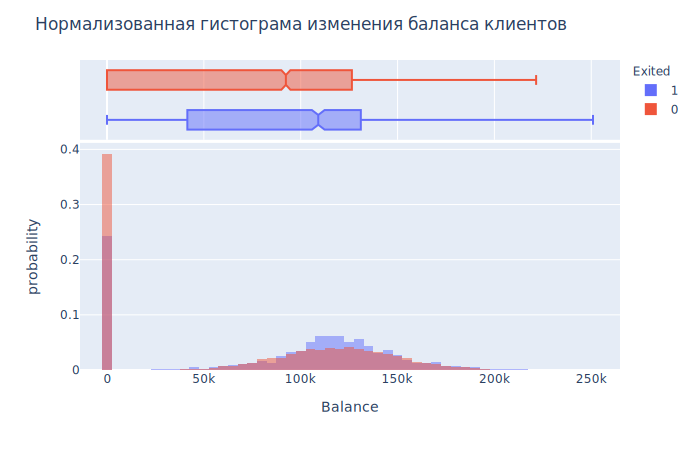

In [13]:
fig = px.histogram(df, x="Balance", color="Exited", marginal="box", histnorm='probability', barmode='overlay')
fig.update_layout(title_text='Нормализованная гистограма изменения баланса клиентов')
fig.show('svg')

По получившейся гистограмме видно, что значительную долю клиентов составляют клиенты с 0-м балансом. Примечательно, что среди ушедших клиентов доля клиентов с 0-м балансом почти в 2 раза ниже. Это говорит о том, что банк покидают клиенты, у которых имеются накопления и которые, предположительно, нашли более выгодные условия для хранения своих средств.

Не считая пика у нуля, обе гистограммы имеют нормальное распределение, при этом диаграммы размаха показывают, что выбросы для обоих гистограмм отсутствуют. Т.к. клиенты с нулевым балансом представляют значительную часть выборки, то они должны быть оставлены в датасете, таким образом предобработка данного столбца не требуется.

Далее проведем кодирование категориальных признаков. В дальнейшем будем использовать различные модели, в зависимости от модели необходимо применять различные типы кодирования. В случае логистической регрессии подойдет техника прямого кодирования (англ. One-Hot Encoding, OHE), а в случае деревьев и лесов - порядкового кодирования (ordinal encoding), поэтому далее будет подготовлено два набора данных для обоих видов кодирования.

In [14]:
# кодирование OHE
df_ohe = pd.get_dummies(df, drop_first=True, columns=['Geography', 'Gender'])
display(df_ohe.head(10))

# кодирование OE
encoder = OrdinalEncoder()
df_ord = df.copy()
df_ord[['Geography', 'Gender']] = encoder.fit_transform(df_ord[['Geography', 'Gender']])
display(df_ord.head(10))

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.000,1,1,1,101348.880,1,0,0,0
1,608,41,1,83807.860,1,0,1,112542.580,0,0,1,0
2,502,42,8,159660.800,3,1,0,113931.570,1,0,0,0
3,699,39,1,0.000,2,0,0,93826.630,0,0,0,0
4,850,43,2,125510.820,1,1,1,79084.100,0,0,1,0
5,645,44,8,113755.780,2,1,0,149756.710,1,0,1,1
6,822,50,7,0.000,2,1,1,10062.800,0,0,0,1
7,376,29,4,115046.740,4,1,0,119346.880,1,1,0,0
8,501,44,4,142051.070,2,0,1,74940.500,0,0,0,1
9,684,27,2,134603.880,1,1,1,71725.730,0,0,0,1


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0.000,0.000,42,2,0.000,1,1,1,101348.880,1
1,608,2.000,0.000,41,1,83807.860,1,0,1,112542.580,0
2,502,0.000,0.000,42,8,159660.800,3,1,0,113931.570,1
3,699,0.000,0.000,39,1,0.000,2,0,0,93826.630,0
4,850,2.000,0.000,43,2,125510.820,1,1,1,79084.100,0
5,645,2.000,1.000,44,8,113755.780,2,1,0,149756.710,1
6,822,0.000,1.000,50,7,0.000,2,1,1,10062.800,0
7,376,1.000,0.000,29,4,115046.740,4,1,0,119346.880,1
8,501,0.000,1.000,44,4,142051.070,2,0,1,74940.500,0
9,684,0.000,1.000,27,2,134603.880,1,1,1,71725.730,0


Следующим этапом подготовки признаков является их масштабирование. Масштабирование выполняется с помощью инструмента StandardScaler, тренировку которого нужно проводить на обцчающей выборке, поэтому перед проведением масштабирования, проведем деление получившихся датасетов на обучающие, тестовые и валидационные.

In [15]:
# Готовим признаки для модели с кодировкой OHE
target_ohe = df_ohe['Exited']
features_ohe = df_ohe.drop('Exited', axis=1)

features_train_ohe, features_valid_test_ohe, target_train_ohe, target_valid_test_ohe = train_test_split(
features_ohe, target_ohe, test_size=0.4, stratify=target_ohe, random_state=12345) # разделили выборки в пропорции 4 к 10

features_test_ohe, features_valid_ohe, target_test_ohe, target_valid_ohe = train_test_split(
features_valid_test_ohe, target_valid_test_ohe, test_size=0.5, stratify=target_valid_test_ohe, random_state=12345) # разделили вал-ую и тестовую пополам


# проверим получившиеся размеры выборок
print(features_train_ohe.shape)
print(features_valid_ohe.shape)
print(features_test_ohe.shape)

(5454, 11)
(1819, 11)
(1818, 11)


In [16]:
# Готовим признаки для модели с кодировкой OrdE
target_ord = df_ord['Exited']
features_ord = df_ord.drop('Exited', axis=1)

features_train_ord, features_valid_test_ord, target_train_ord, target_valid_test_ord = train_test_split(
features_ord, target_ord, test_size=0.4, stratify=target_ord, random_state=12345) # разделили выборки в пропорции 4 к 10

features_test_ord, features_valid_ord, target_test_ord, target_valid_ord = train_test_split(
features_valid_test_ord, target_valid_test_ord, test_size=0.5, stratify=target_valid_test_ord, random_state=12345) # разделили вал-ую и тестовую пополам


# проверим получившиеся размеры выборок
print(features_train_ord.shape)
print(features_valid_ord.shape)
print(features_test_ord.shape)

(5454, 10)
(1819, 10)
(1818, 10)


Проведем масштабирование количественных признаков.

In [17]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

#масштабируем выборки с кодировкой ohe
scaler_1 = StandardScaler()
scaler_1.fit(features_train_ohe[numeric])

features_train_ohe[numeric] = scaler_1.transform(features_train_ohe[numeric])
features_valid_ohe[numeric] = scaler_1.transform(features_valid_ohe[numeric])
features_test_ohe[numeric] = scaler_1.transform(features_test_ohe[numeric])
features_train_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
9723,-1.293,-0.661,0.686,0.787,-0.911,0,0,-0.224,0,0,1
1224,-1.564,0.778,1.034,0.834,-0.911,1,0,1.383,0,1,0
8377,1.582,0.107,-0.357,-1.223,0.789,1,1,-0.308,0,1,1
8014,0.842,0.011,-1.053,0.807,-0.911,1,1,-0.431,0,1,0
2491,-0.397,-1.237,-0.357,-1.223,0.789,1,1,1.393,0,1,0


In [18]:
#масштабируем выборки с кодировкой ordinal
scaler_2 = StandardScaler()
scaler_2.fit(features_train_ord[numeric])

features_train_ord[numeric] = scaler_2.transform(features_train_ord[numeric])
features_valid_ord[numeric] = scaler_2.transform(features_valid_ord[numeric])
features_test_ord[numeric] = scaler_2.transform(features_test_ord[numeric])
features_train_ord.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
9723,-1.293,0.000,1.000,-0.661,0.686,0.787,-0.911,0,0,-0.224
1224,-1.564,2.000,0.000,0.778,1.034,0.834,-0.911,1,0,1.383
8377,1.582,2.000,1.000,0.107,-0.357,-1.223,0.789,1,1,-0.308
8014,0.842,2.000,0.000,0.011,-1.053,0.807,-0.911,1,1,-0.431
2491,-0.397,2.000,0.000,-1.237,-0.357,-1.223,0.789,1,1,1.393


Данные предобработаны и готовы к созданию моделей.

## 3 Исследование баланса классов

0   0.796
1   0.204
Name: Exited, dtype: float64


(array([0, 1], dtype=int64), [Text(0, 0, '0'), Text(1, 0, '1')])

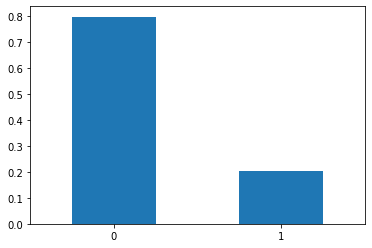

In [21]:
class_frequency = df_ohe['Exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.xticks(rotation='horizontal')

Видно, что соотношение классов далеко от 1:1. Если создать константную модель, которая проставляет 0 (ни один клиент не уйдет), то ее accuracy будет равно около 0.8. Видим, что значение достаточно высоко и модель нужно строить с учетом дисбаланса классов.
Изначально построим модели без учета дисбаланса классов, и далее с учетом дисбаланса.

## 4 Создание моделей без учета дисбаланса

Построим модели логистической регрессии, решающего дерева и случайного леса без учета дисбаланса классов. Создадим служебные функции с выводом необходимых метрик.

In [22]:
# Создадим функцию для построения кривой ROC
def roc_plot (model, features, target):
    
    probabilities_valid = model.predict_proba(features)
    probabilities_one_valid = probabilities_valid[:, 1]
    fpr, tpr, thresholds = roc_curve(target, probabilities_one_valid) 

    plt.figure()

    plt.plot(fpr, tpr, linestyle='-')

    plt.plot([0, 1], [0, 1], linestyle='--')

    plt.ylim([0, 1])
    plt.xlim([0, 1])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('ROC-кривая')
    plt.show()

In [23]:
# создадим функцию для расчета всех метрик
def metrics_calc (model, features, target):
    predicted = model.predict(features)
    accuracy = accuracy_score(target, predicted) # проверка качества
    recall = recall_score(target, predicted) # полнота
    precision = precision_score(target, predicted) # точность
    f1 = f1_score(target, predicted)
    
    probabilities = model.predict_proba(features)
    probabilities_one = probabilities[:, 1]
    auc_roc = roc_auc_score(target, probabilities_one)
    
    return accuracy, recall, precision, f1, auc_roc

# создадим функцию для вывода всех метрик
def metrics (model, features, target):
     
    predicted = model.predict(features)
    accuracy, recall, precision, f1, auc_roc = metrics_calc(model, features, target)
         
    print('Accuracy модели равна', accuracy)
    print('Полнота модели равна', recall)
    print('Точность модели равна', precision)
    print('F1 модели равна', f1)
    print('AUC-ROC модели равна', auc_roc)
    print()

    cm = confusion_matrix(target, predicted)
    #print(cm)
    
    #plt.figure(figsize = (10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap= 'PRGn', linewidths=3, linecolor='white')
    plt.xlabel('Предсказания')
    plt.ylabel('Ответы')
    plt.title('Матрица ошибок')

In [24]:
# создадим таблицу для хранения результатов
d = {'disbalance':[], 'model': [], 'accuracy':[], 'recall': [], 'precision':[], 'F1': [], 'AUC-ROC': []}
results = pd.DataFrame(data=d)
results

,disbalance,model,accuracy,recall,precision,F1,AUC-ROC


In [25]:
# создадим функцию для добавления результатов в таблицу
def model_res(disbalance, model_name, model, features, target):
    accuracy, recall, precision, f1, auc_roc = metrics_calc(model, features, target)
    results.loc[len(results)] = [disbalance, model_name, accuracy, recall, precision, f1, auc_roc]
    if len(results) > 0: # исключим дублировании при неоднократном выполнении функции для одной и той же модели
        results.drop_duplicates(inplace=True)
    display(results)

### 4.1 Логистическая регрессия.

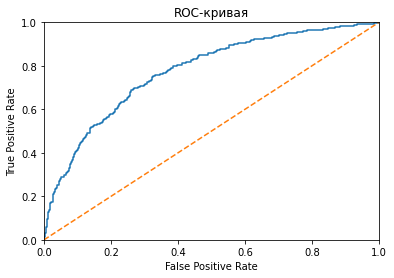

Accuracy модели равна 0.8158328752061572
Полнота модели равна 0.24528301886792453
Точность модели равна 0.6232876712328768
F1 модели равна 0.35203094777562866
AUC-ROC модели равна 0.7743592798320205



,disbalance,model,accuracy,recall,precision,F1,AUC-ROC
0,yes,LogisticRegression,0.816,0.245,0.623,0.352,0.774


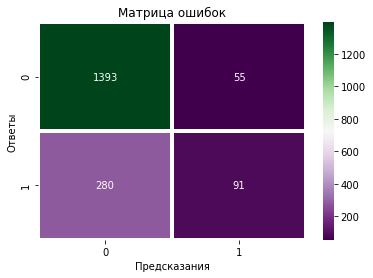

In [26]:
lr = LogisticRegression(random_state=12345, solver='liblinear')
lr.fit(features_train_ohe, target_train_ohe)

roc_plot(lr, features_valid_ohe, target_valid_ohe)
metrics(lr, features_valid_ohe, target_valid_ohe)
model_res('yes', 'LogisticRegression', lr, features_valid_ohe, target_valid_ohe)

Несмотря на высокую долю правильных ответов, модель имеет очень низкое значение F1-меры, что обусловлено наличием большого количества ложноотрицательных ответов (FN). Ложноотрицательные ответы ведут к уменьшению полноты, которая негативно влияет на меру F1.

### 4.2 Решающее дерево

Создадим модель на основе решающего дерева без изменения гиперпараметров. В случае деревьев и лесов будем использвать выборки с кодировкой ordinal.

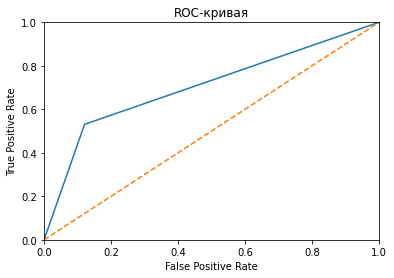

Accuracy модели равна 0.8081363386476086
Полнота модели равна 0.5309973045822103
Точность модели равна 0.5295698924731183
F1 модели равна 0.5302826379542396
AUC-ROC модели равна 0.705070475495525



,disbalance,model,accuracy,recall,precision,F1,AUC-ROC
0,yes,LogisticRegression,0.816,0.245,0.623,0.352,0.774
1,yes,Simple DecisionTree,0.808,0.531,0.530,0.530,0.705


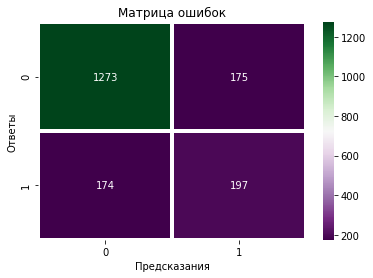

In [27]:
dt = DecisionTreeClassifier(random_state=12345)
dt.fit(features_train_ord, target_train_ord)
roc_plot(dt, features_valid_ord, target_valid_ord)
metrics(dt, features_valid_ord, target_valid_ord)
model_res('yes', 'Simple DecisionTree', dt, features_valid_ord, target_valid_ord)

F1 значительно подросла, а вот AUC-ROC наоборот снизилась, дерево приняло лишь одно решение, после которого модель никак не менялась. Попробуем подобрать более оптимальные гиперпараметры, для этой цели будем использовать функционал GridSearchCV.

In [25]:
'''
%%time
tree = DecisionTreeClassifier(random_state=12345) # создаем модель с заданной глубиной дерева
tree.fit(features_train_ord, target_train_ord)

    
tree_params = {'max_depth': range(1,11),
              'criterion': ['gini', 'entropy'],
              'min_samples_leaf': range(1,20),
              'min_samples_split': range(2,40),
              }

tree_grid = GridSearchCV(tree, tree_params,
                         cv=5, verbose=3)

tree_grid.fit(features_train_ord, target_train_ord)
tree_grid.best_params_
'''

"\n%%time\ntree = DecisionTreeClassifier(random_state=12345) # создаем модель с заданной глубиной дерева\ntree.fit(features_train_ord, target_train_ord)\n\n    \ntree_params = {'max_depth': range(1,11),\n              'criterion': ['gini', 'entropy'],\n              'min_samples_leaf': range(1,20),\n              'min_samples_split': range(2,40),\n              }\n\ntree_grid = GridSearchCV(tree, tree_params,\n                         cv=5, verbose=3)\n\ntree_grid.fit(features_train_ord, target_train_ord)\ntree_grid.best_params_\n"

Построим дерево с найденными GridSearchCV параметрами (указаны в параметрах модели).

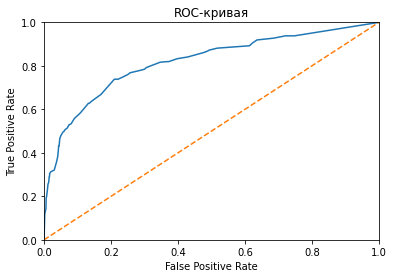

Accuracy модели равна 0.8537658053875756
Полнота модели равна 0.46630727762803237
Точность модели равна 0.7178423236514523
F1 модели равна 0.5653594771241831
AUC-ROC модели равна 0.8177419174695835



,disbalance,model,accuracy,recall,precision,F1,AUC-ROC
0,yes,LogisticRegression,0.816,0.245,0.623,0.352,0.774
1,yes,Simple DecisionTree,0.808,0.531,0.530,0.530,0.705
2,yes,HyperParametrs DecisionTree,0.854,0.466,0.718,0.565,0.818


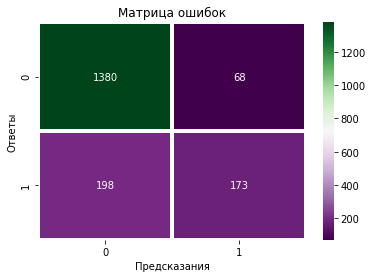

In [28]:
dt_res = DecisionTreeClassifier(random_state=12345, criterion='entropy', max_depth=8, min_samples_leaf=8, 
                                min_samples_split=39)
dt_res.fit(features_train_ord, target_train_ord)

roc_plot(dt_res, features_valid_ord, target_valid_ord)
metrics(dt_res, features_valid_ord, target_valid_ord)
model_res('yes', 'HyperParametrs DecisionTree', dt_res, features_valid_ord, target_valid_ord)

Удалось поднять F1 еще почти на 3,5 %, также значительно выросло значение AUC-ROC. Тем не менее в предсказаниях модели все еще очень много ответов FN (ошибка 2-го рода), что является критичным замечанием к модели, т.к. основная задача - это удержать клиента, поэтому идентифицировать его как уходящего (допустить ошибку 1-го рода) не так страшно, как не сделать этого. Далее проверим работу модели на основе алгоритма RandomForest, сначала без поиска оптимальных гиперпараметров, потом с поиском.

### 4.3 Случайный лес

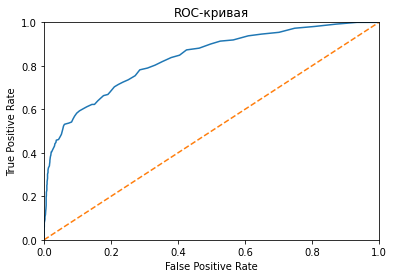

Accuracy модели равна 0.8592633315008247
Полнота модели равна 0.4474393530997305
Точность модели равна 0.7649769585253456
F1 модели равна 0.564625850340136
AUC-ROC модели равна 0.8338604413932779



,disbalance,model,accuracy,recall,precision,F1,AUC-ROC
0,yes,LogisticRegression,0.816,0.245,0.623,0.352,0.774
1,yes,Simple DecisionTree,0.808,0.531,0.530,0.530,0.705
2,yes,HyperParametrs DecisionTree,0.854,0.466,0.718,0.565,0.818
3,yes,Simple RandomForest,0.859,0.447,0.765,0.565,0.834


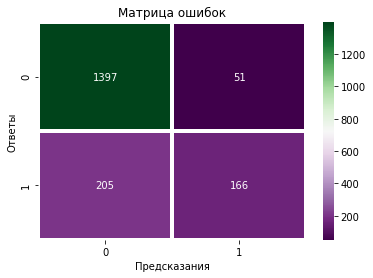

In [29]:
# создадим модель на основе случайного леса без регулировки гиперпараметров
rfc = RandomForestClassifier(random_state=12345)
rfc.fit(features_train_ord, target_train_ord)

roc_plot(rfc, features_valid_ord, target_valid_ord)
metrics(rfc, features_valid_ord, target_valid_ord)
model_res('yes', 'Simple RandomForest', rfc, features_valid_ord, target_valid_ord)

Получили значения метрик, близкие к метрикам решающего дерева с настроенными гиперпараметрами. Подберем наиболее оптимальные гиперпараметры для модели случайного леса.

In [28]:
'''
%%time
rf_2 = RandomForestClassifier(random_state=12345) # создаем модель с заданной глубиной дерева
rf_2.fit(features_train_ord, target_train_ord)

forest_params = {'n_estimators': range(10, 51, 10),
                 'max_depth': range(1,11),               
              'criterion': ['gini', 'entropy'],
              'min_samples_leaf': range(1,11),
              'min_samples_split': range(2,11),
                'bootstrap':[True, False]}

forest_grid = GridSearchCV(rf_2, forest_params,
                         cv=5, verbose=3)

forest_grid.fit(features_train_ord, target_train_ord)
forest_grid.best_params_
'''

"\n%%time\nrf_2 = RandomForestClassifier(random_state=12345) # создаем модель с заданной глубиной дерева\nrf_2.fit(features_train_ord, target_train_ord)\n\nforest_params = {'n_estimators': range(10, 51, 10),\n                 'max_depth': range(1,11),               \n              'criterion': ['gini', 'entropy'],\n              'min_samples_leaf': range(1,11),\n              'min_samples_split': range(2,11),\n                'bootstrap':[True, False]}\n\nforest_grid = GridSearchCV(rf_2, forest_params,\n                         cv=5, verbose=3)\n\nforest_grid.fit(features_train_ord, target_train_ord)\nforest_grid.best_params_\n"

Построим случайный лес с найденными GridSearchCV параметрами (указаны в параметрах модели).

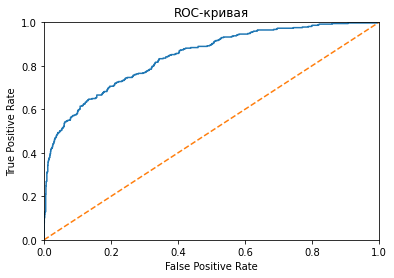

Accuracy модели равна 0.8647608576140736
Полнота модели равна 0.4393530997304582
Точность модели равна 0.8109452736318408
F1 модели равна 0.5699300699300699
AUC-ROC модели равна 0.8428625411386279



,disbalance,model,accuracy,recall,precision,F1,AUC-ROC
0,yes,LogisticRegression,0.816,0.245,0.623,0.352,0.774
1,yes,Simple DecisionTree,0.808,0.531,0.530,0.530,0.705
2,yes,HyperParametrs DecisionTree,0.854,0.466,0.718,0.565,0.818
3,yes,Simple RandomForest,0.859,0.447,0.765,0.565,0.834
4,yes,HyperParametrs RandomForest,0.865,0.439,0.811,0.570,0.843


Wall time: 494 ms


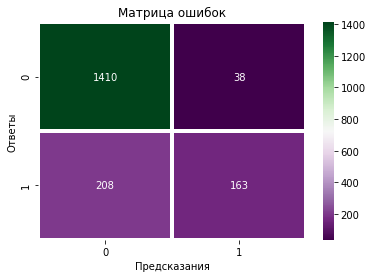

In [30]:
%%time
rf_res = RandomForestClassifier(random_state=12345, bootstrap=True, criterion='gini', max_depth=10, min_samples_leaf=1,
                                min_samples_split=8, n_estimators=30) 
rf_res.fit(features_train_ord, target_train_ord)

roc_plot(rf_res, features_valid_ord, target_valid_ord)
metrics(rf_res, features_valid_ord, target_valid_ord)
model_res('yes', 'HyperParametrs RandomForest', rf_res, features_valid_ord, target_valid_ord)

Мы получили 5 моделей без учета дисбаланса классов. По итогу проверки на валидационной выборке лучшей моделью по параметрам F1 и AUC-ROC является случайный лес с подобранными гиперпараметрами, - 0,57 и 0,843 соответственно. Несмотря на наилучшее качество модели, она обладает не самой лучшей полнотой, которая напрямую характеризует ошибку второго рода, т.е. ошибку, что клиент уходит. Если бы целевая метрика была выполнена во всех моделях, то в таком случае лучше бы было выбрать модель обычного решающего дерева без настроенных гиперпараметров, т.к. данная модель обладает меньшей ошибкой 2-го рода.

Продолжим тестирование уже с учетом дисбалансов классов.

## 5 Создание моделей c учетом дисбаланса

### 5.1 Взвешивание классов

Применим модели, которые использовались в предыдущей части, и укажем для каждой из них аргумент *class_weight* равный balanced.

#### 5.1.1 Логистическая регрессия

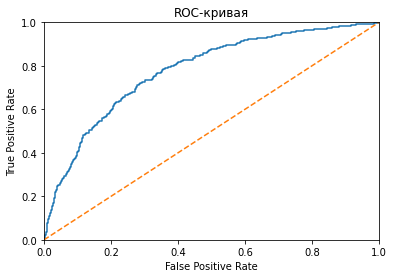

Accuracy модели равна 0.7207256734469488
Полнота модели равна 0.7088948787061995
Точность модели равна 0.39668174962292607
F1 модели равна 0.5087040618955513
AUC-ROC модели равна 0.778158553111644



,disbalance,model,accuracy,recall,precision,F1,AUC-ROC
0,yes,LogisticRegression,0.816,0.245,0.623,0.352,0.774
1,yes,Simple DecisionTree,0.808,0.531,0.530,0.530,0.705
2,yes,HyperParametrs DecisionTree,0.854,0.466,0.718,0.565,0.818
3,yes,Simple RandomForest,0.859,0.447,0.765,0.565,0.834
4,yes,HyperParametrs RandomForest,0.865,0.439,0.811,0.570,0.843
5,Weighted,LogisticRegression,0.721,0.709,0.397,0.509,0.778


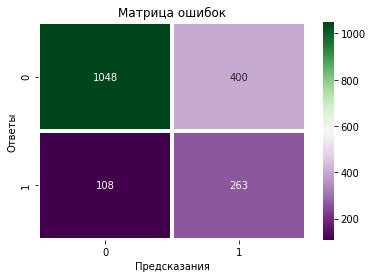

In [31]:
lr_1 = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
lr_1.fit(features_train_ohe, target_train_ohe)

roc_plot(lr_1, features_valid_ohe, target_valid_ohe)
metrics(lr_1, features_valid_ohe, target_valid_ohe)
model_res('Weighted', 'LogisticRegression', lr_1, features_valid_ohe, target_valid_ohe)

Из результирующей таблицы видно, что применение аргумента *class_weight* позволило значительно увеличить метрику F1 по сравнению с начальной логистической регрессией. Также возросло и значение полноты и несколько снизилось значение точности.

#### 5.1.2 Решающее дерево

Выведем решающее дерево без гиперпараметров.

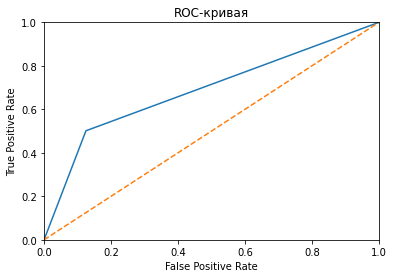

Accuracy модели равна 0.7987905442550852
Полнота модели равна 0.5013477088948787
Точность модели равна 0.5068119891008175
F1 модели равна 0.5040650406504066
AUC-ROC модели равна 0.6881738544474393



,disbalance,model,accuracy,recall,precision,F1,AUC-ROC
0,yes,LogisticRegression,0.816,0.245,0.623,0.352,0.774
1,yes,Simple DecisionTree,0.808,0.531,0.530,0.530,0.705
2,yes,HyperParametrs DecisionTree,0.854,0.466,0.718,0.565,0.818
3,yes,Simple RandomForest,0.859,0.447,0.765,0.565,0.834
4,yes,HyperParametrs RandomForest,0.865,0.439,0.811,0.570,0.843
5,Weighted,LogisticRegression,0.721,0.709,0.397,0.509,0.778
6,Weighted,Simple DecisionTree,0.799,0.501,0.507,0.504,0.688


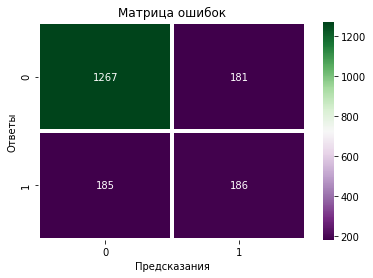

In [32]:
dt_1 = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
dt_1.fit(features_train_ord, target_train_ord)
roc_plot(dt_1, features_valid_ord, target_valid_ord)
metrics(dt_1, features_valid_ord, target_valid_ord)
model_res('Weighted', 'Simple DecisionTree', dt_1, features_valid_ord, target_valid_ord)

С применением class_weight='balanced' результат получился хуже, чем без него. Проверим на дереве с гиперпараметрами.

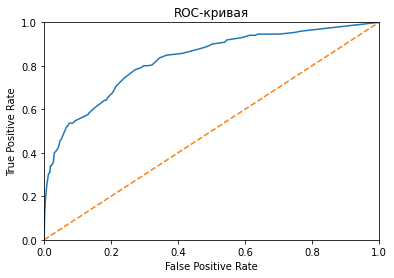

Accuracy модели равна 0.7713029136888401
Полнота модели равна 0.6765498652291105
Точность модели равна 0.45886654478976235
F1 модели равна 0.5468409586056645
AUC-ROC модели равна 0.8270055546455004



,disbalance,model,accuracy,recall,precision,F1,AUC-ROC
0,yes,LogisticRegression,0.816,0.245,0.623,0.352,0.774
1,yes,Simple DecisionTree,0.808,0.531,0.530,0.530,0.705
2,yes,HyperParametrs DecisionTree,0.854,0.466,0.718,0.565,0.818
3,yes,Simple RandomForest,0.859,0.447,0.765,0.565,0.834
4,yes,HyperParametrs RandomForest,0.865,0.439,0.811,0.570,0.843
5,Weighted,LogisticRegression,0.721,0.709,0.397,0.509,0.778
6,Weighted,Simple DecisionTree,0.799,0.501,0.507,0.504,0.688
7,Weighted,HyperParametrs DecisionTree,0.771,0.677,0.459,0.547,0.827


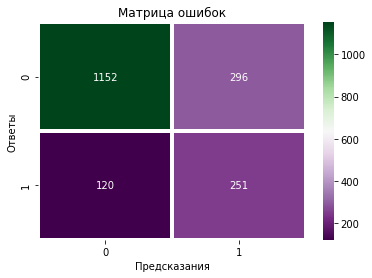

In [33]:
dt_res_1 = DecisionTreeClassifier(random_state=12345, criterion='entropy', max_depth=8, min_samples_leaf=8, 
                                  min_samples_split=39, class_weight='balanced')
dt_res_1.fit(features_train_ord, target_train_ord)

roc_plot(dt_res_1, features_valid_ord, target_valid_ord)
metrics(dt_res_1, features_valid_ord, target_valid_ord)
model_res('Weighted', 'HyperParametrs DecisionTree', dt_res_1, features_valid_ord, target_valid_ord)

По сравнению с моделью без гиперпараметров метрика AUC-ROC выросла, метрика F1-снизилась. Также выросла полнота, что говорит об уменьшении ошибок второго рода в данной модели. Это подтверждается и матрицей ошибок - количество ложноотрицательных ответов уменьшилось.

#### 5.1.3 Случайный лес

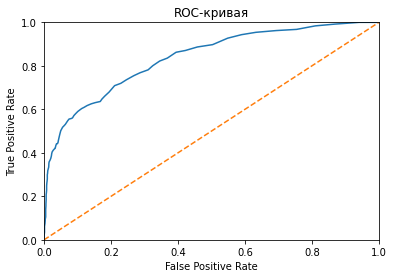

Accuracy модели равна 0.8554150632215503
Полнота модели равна 0.42048517520215634
Точность модели равна 0.7647058823529411
F1 модели равна 0.542608695652174
AUC-ROC модели равна 0.8367810978243063



,disbalance,model,accuracy,recall,precision,F1,AUC-ROC
0,yes,LogisticRegression,0.816,0.245,0.623,0.352,0.774
1,yes,Simple DecisionTree,0.808,0.531,0.530,0.530,0.705
2,yes,HyperParametrs DecisionTree,0.854,0.466,0.718,0.565,0.818
3,yes,Simple RandomForest,0.859,0.447,0.765,0.565,0.834
4,yes,HyperParametrs RandomForest,0.865,0.439,0.811,0.570,0.843
5,Weighted,LogisticRegression,0.721,0.709,0.397,0.509,0.778
6,Weighted,Simple DecisionTree,0.799,0.501,0.507,0.504,0.688
7,Weighted,HyperParametrs DecisionTree,0.771,0.677,0.459,0.547,0.827
8,Weighted,Simple RandomForest,0.855,0.420,0.765,0.543,0.837


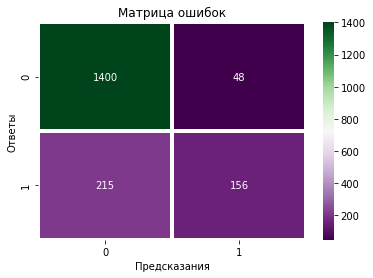

In [34]:
# создадим модель на основе случайного леса без регулировки гиперпараметров
rfc_1 = RandomForestClassifier(random_state=12345, class_weight='balanced')
rfc_1.fit(features_train_ord, target_train_ord)

roc_plot(rfc_1, features_valid_ord, target_valid_ord)
metrics(rfc_1, features_valid_ord, target_valid_ord)
model_res('Weighted', 'Simple RandomForest', rfc_1, features_valid_ord, target_valid_ord)

Аналогично решающему дереву о сравнению с моделью без гиперпараметров метрика AUC-ROC выросла, метрика F1-снизилась, полнота снизилась.

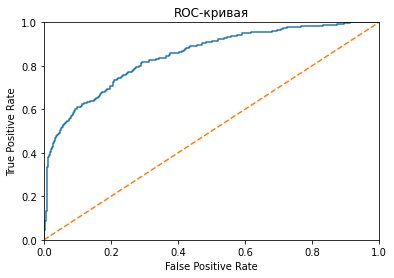

Accuracy модели равна 0.8416712479384277
Полнота модели равна 0.6091644204851752
Точность модели равна 0.6124661246612466
F1 модели равна 0.6108108108108108
AUC-ROC модели равна 0.8465491950976158



,disbalance,model,accuracy,recall,precision,F1,AUC-ROC
0,yes,LogisticRegression,0.816,0.245,0.623,0.352,0.774
1,yes,Simple DecisionTree,0.808,0.531,0.530,0.530,0.705
2,yes,HyperParametrs DecisionTree,0.854,0.466,0.718,0.565,0.818
3,yes,Simple RandomForest,0.859,0.447,0.765,0.565,0.834
4,yes,HyperParametrs RandomForest,0.865,0.439,0.811,0.570,0.843
5,Weighted,LogisticRegression,0.721,0.709,0.397,0.509,0.778
6,Weighted,Simple DecisionTree,0.799,0.501,0.507,0.504,0.688
7,Weighted,HyperParametrs DecisionTree,0.771,0.677,0.459,0.547,0.827
8,Weighted,Simple RandomForest,0.855,0.420,0.765,0.543,0.837
9,Weighted,HyperParametrs RandomForest,0.842,0.609,0.612,0.611,0.847


Wall time: 550 ms


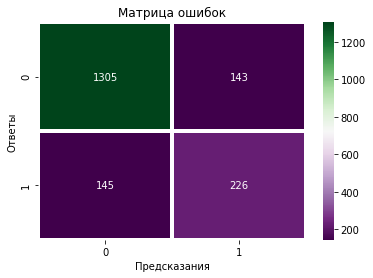

In [35]:
%%time
rf_res_1 = RandomForestClassifier(random_state=12345, bootstrap=True, criterion='gini', max_depth=10, min_samples_leaf=1,
                                min_samples_split=8, n_estimators=30, class_weight='balanced') 
rf_res_1.fit(features_train_ord, target_train_ord)

roc_plot(rf_res_1, features_valid_ord, target_valid_ord)
metrics(rf_res_1, features_valid_ord, target_valid_ord)
model_res('Weighted', 'HyperParametrs RandomForest', rf_res_1, features_valid_ord, target_valid_ord)

По итогу применения метода взвешивания классов удалось получить наилучшие параметры обеих контролируемых метрик (F1 и AUC-ROC) при применении метода к модели на основе случайного леса с подобранными гиперпараметрами. Поставленная задача по достижению значения метрики F1 выполнена, данная модель может быть принята как одна из лучших. Продолжим поиск наилучших моделей с помощью методов увеличения и умньшения выборок.

### 5.2 Увеличение выборки

In [36]:
# создадим функцию по увеличению выборки
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [37]:
# для определения repeat посмотрим насколько не сбалансированы классы
target_train_ord.value_counts()

0    4342
1    1112
Name: Exited, dtype: int64

Количество значений в классах отличается в 4 раза, значит repeat примем равным 4. Преобразуем обе выборки (ohe и ordinal).

In [38]:
repeat = 4
features_train_ord_up, target_train_ord_up = upsample(features_train_ord, target_train_ord, repeat)
features_train_ohe_up, target_train_ohe_up = upsample(features_train_ohe, target_train_ohe, repeat)
print(features_train_ord_up.shape)
print(features_train_ohe_up.shape)

(8790, 10)
(8790, 11)


In [39]:
print(target_train_ord_up.value_counts())
print(target_train_ohe_up.value_counts())

1    4448
0    4342
Name: Exited, dtype: int64
1    4448
0    4342
Name: Exited, dtype: int64


Классы сбалансированы, перходим к построению моделей.

#### 5.2.1 Логистическая регрессия

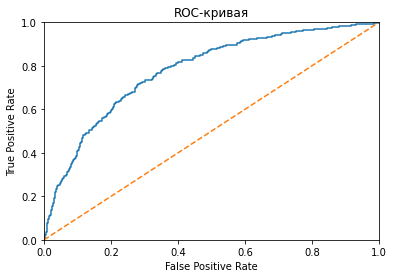

Accuracy модели равна 0.7135788894997251
Полнота модели равна 0.7142857142857143
Точность модели равна 0.3897058823529412
F1 модели равна 0.5042816365366317
AUC-ROC модели равна 0.7781846137808819



,disbalance,model,accuracy,recall,precision,F1,AUC-ROC
0,yes,LogisticRegression,0.816,0.245,0.623,0.352,0.774
1,yes,Simple DecisionTree,0.808,0.531,0.530,0.530,0.705
2,yes,HyperParametrs DecisionTree,0.854,0.466,0.718,0.565,0.818
3,yes,Simple RandomForest,0.859,0.447,0.765,0.565,0.834
4,yes,HyperParametrs RandomForest,0.865,0.439,0.811,0.570,0.843
5,Weighted,LogisticRegression,0.721,0.709,0.397,0.509,0.778
6,Weighted,Simple DecisionTree,0.799,0.501,0.507,0.504,0.688
7,Weighted,HyperParametrs DecisionTree,0.771,0.677,0.459,0.547,0.827
8,Weighted,Simple RandomForest,0.855,0.420,0.765,0.543,0.837
9,Weighted,HyperParametrs RandomForest,0.842,0.609,0.612,0.611,0.847


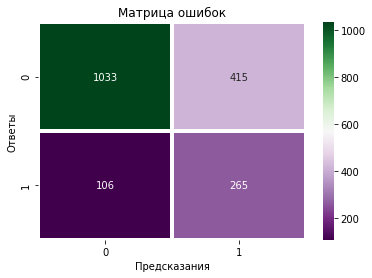

In [40]:
lr_2 = LogisticRegression(random_state=12345, solver='liblinear')
lr_2.fit(features_train_ohe_up, target_train_ohe_up)

roc_plot(lr_2, features_valid_ohe, target_valid_ohe)
metrics(lr_2, features_valid_ohe, target_valid_ohe)
model_res('UpSampling', 'LogisticRegression', lr_2, features_valid_ohe, target_valid_ohe)

По сравнению с моделью с выполнением взвешивания классов метрика AUC-ROC не изменилась, но несколько снизилась мера F1. При этом произошло повышение полноты, а значит и уменьшении ошибки 2-го рода.

#### 5.2.2 Решающее дерево

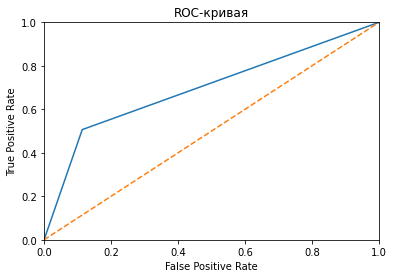

Accuracy модели равна 0.8086860912589334
Полнота модели равна 0.5067385444743935
Точность модели равна 0.5325779036827195
F1 модели равна 0.5193370165745855
AUC-ROC модели равна 0.6963941341156498



,disbalance,model,accuracy,recall,precision,F1,AUC-ROC
0,yes,LogisticRegression,0.816,0.245,0.623,0.352,0.774
1,yes,Simple DecisionTree,0.808,0.531,0.530,0.530,0.705
2,yes,HyperParametrs DecisionTree,0.854,0.466,0.718,0.565,0.818
3,yes,Simple RandomForest,0.859,0.447,0.765,0.565,0.834
4,yes,HyperParametrs RandomForest,0.865,0.439,0.811,0.570,0.843
5,Weighted,LogisticRegression,0.721,0.709,0.397,0.509,0.778
6,Weighted,Simple DecisionTree,0.799,0.501,0.507,0.504,0.688
7,Weighted,HyperParametrs DecisionTree,0.771,0.677,0.459,0.547,0.827
8,Weighted,Simple RandomForest,0.855,0.420,0.765,0.543,0.837
9,Weighted,HyperParametrs RandomForest,0.842,0.609,0.612,0.611,0.847


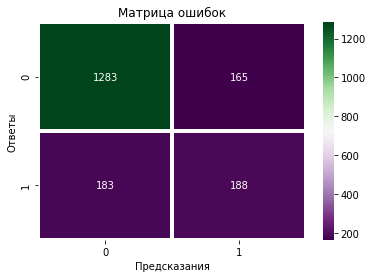

In [41]:
dt_2 = DecisionTreeClassifier(random_state=12345)
dt_2.fit(features_train_ord_up, target_train_ord_up)
roc_plot(dt_2, features_valid_ord, target_valid_ord)
metrics(dt_2, features_valid_ord, target_valid_ord)
model_res('UpSampling', 'Simple DecisionTree', dt_2, features_valid_ord, target_valid_ord)

Методика upsampling никак не помогла улучшить показатели решающего дерева. Т.к. выборка изменилась, попробуем подобрать наиболее оптимальные гиперпараметры для решающего дерева.

In [41]:
'''
%%time
tree = DecisionTreeClassifier(random_state=12345) # создаем модель с заданной глубиной дерева
tree.fit(features_train_ord_up, target_train_ord_up)

    
tree_params = {'max_depth': range(1,11),
              'criterion': ['gini', 'entropy'],
              'min_samples_leaf': range(1,20),
              'min_samples_split': range(2,40),
              }

tree_grid = GridSearchCV(tree, tree_params,
                         cv=5, verbose=3)

tree_grid.fit(features_train_ord_up, target_train_ord_up)
tree_grid.best_params_
'''

"\n%%time\ntree = DecisionTreeClassifier(random_state=12345) # создаем модель с заданной глубиной дерева\ntree.fit(features_train_ord_up, target_train_ord_up)\n\n    \ntree_params = {'max_depth': range(1,11),\n              'criterion': ['gini', 'entropy'],\n              'min_samples_leaf': range(1,20),\n              'min_samples_split': range(2,40),\n              }\n\ntree_grid = GridSearchCV(tree, tree_params,\n                         cv=5, verbose=3)\n\ntree_grid.fit(features_train_ord_up, target_train_ord_up)\ntree_grid.best_params_\n"

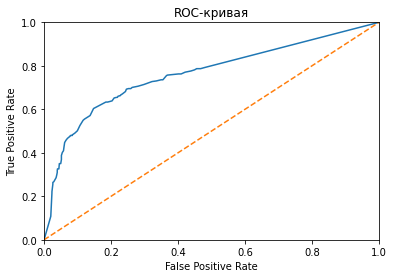

Accuracy модели равна 0.7465640461792193
Полнота модели равна 0.6711590296495957
Точность модели равна 0.42346938775510207
F1 модели равна 0.5192909280500522
AUC-ROC модели равна 0.7624058092954684



,disbalance,model,accuracy,recall,precision,F1,AUC-ROC
0,yes,LogisticRegression,0.816,0.245,0.623,0.352,0.774
1,yes,Simple DecisionTree,0.808,0.531,0.530,0.530,0.705
2,yes,HyperParametrs DecisionTree,0.854,0.466,0.718,0.565,0.818
3,yes,Simple RandomForest,0.859,0.447,0.765,0.565,0.834
4,yes,HyperParametrs RandomForest,0.865,0.439,0.811,0.570,0.843
5,Weighted,LogisticRegression,0.721,0.709,0.397,0.509,0.778
6,Weighted,Simple DecisionTree,0.799,0.501,0.507,0.504,0.688
7,Weighted,HyperParametrs DecisionTree,0.771,0.677,0.459,0.547,0.827
8,Weighted,Simple RandomForest,0.855,0.420,0.765,0.543,0.837
9,Weighted,HyperParametrs RandomForest,0.842,0.609,0.612,0.611,0.847


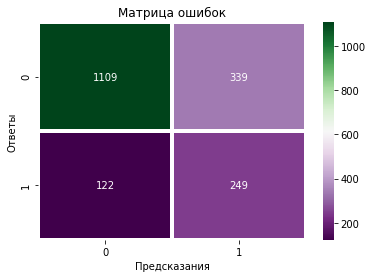

In [42]:
dt_res_2 = DecisionTreeClassifier(random_state=12345, criterion='gini', max_depth=10, 
                                  min_samples_leaf=1, min_samples_split=2)
dt_res_2.fit(features_train_ord_up, target_train_ord_up)

roc_plot(dt_res_2, features_valid_ord, target_valid_ord)
metrics(dt_res_2, features_valid_ord, target_valid_ord)
model_res('UpSampling', 'HyperParametrs DecisionTree', dt_res_2, features_valid_ord, target_valid_ord)

По итогу мы видим, что применение метода взвешивания классов для решающего дерева дало лучшие результаты, чем применение метода увеличения выборки.

#### 5.2.3 Случайный лес

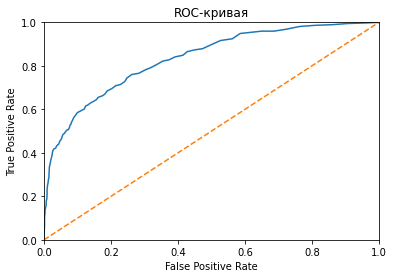

Accuracy модели равна 0.8416712479384277
Полнота модели равна 0.5067385444743935
Точность модели равна 0.6416382252559727
F1 модели равна 0.5662650602409639
AUC-ROC модели равна 0.8342708969337761



,disbalance,model,accuracy,recall,precision,F1,AUC-ROC
0,yes,LogisticRegression,0.816,0.245,0.623,0.352,0.774
1,yes,Simple DecisionTree,0.808,0.531,0.530,0.530,0.705
2,yes,HyperParametrs DecisionTree,0.854,0.466,0.718,0.565,0.818
3,yes,Simple RandomForest,0.859,0.447,0.765,0.565,0.834
4,yes,HyperParametrs RandomForest,0.865,0.439,0.811,0.570,0.843
5,Weighted,LogisticRegression,0.721,0.709,0.397,0.509,0.778
6,Weighted,Simple DecisionTree,0.799,0.501,0.507,0.504,0.688
7,Weighted,HyperParametrs DecisionTree,0.771,0.677,0.459,0.547,0.827
8,Weighted,Simple RandomForest,0.855,0.420,0.765,0.543,0.837
9,Weighted,HyperParametrs RandomForest,0.842,0.609,0.612,0.611,0.847


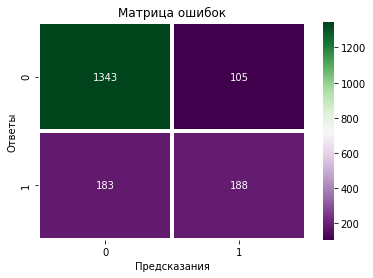

In [43]:
# создадим модель на основе случайного леса без регулировки гиперпараметров
rfc_2 = RandomForestClassifier(random_state=12345)
rfc_2.fit(features_train_ord_up, target_train_ord_up)

roc_plot(rfc_2, features_valid_ord, target_valid_ord)
metrics(rfc_2, features_valid_ord, target_valid_ord)
model_res('UpSampling', 'Simple RandomForest', rfc_2, features_valid_ord, target_valid_ord)

Применение upsampling в случае случайного леса без гиперпараметров также не дало существенных результатов (зафиксировано небольшое увеличение метрики F1).

In [44]:
'''%%time
rf_2 = RandomForestClassifier(random_state=12345)
rf_2.fit(features_train_ord_up, target_train_ord_up)

forest_params = {'n_estimators': range(10, 51, 10),
                 'max_depth': range(1,11),               
              'criterion': ['gini', 'entropy'],
              'min_samples_leaf': range(1,6),
              'min_samples_split': range(2,6)}

forest_grid = GridSearchCV(rf_2, forest_params,
                         cv=5, verbose=3)

forest_grid.fit(features_train_ord_up, target_train_ord_up)
forest_grid.best_params_
'''

"%%time\nrf_2 = RandomForestClassifier(random_state=12345)\nrf_2.fit(features_train_ord_up, target_train_ord_up)\n\nforest_params = {'n_estimators': range(10, 51, 10),\n                 'max_depth': range(1,11),               \n              'criterion': ['gini', 'entropy'],\n              'min_samples_leaf': range(1,6),\n              'min_samples_split': range(2,6)}\n\nforest_grid = GridSearchCV(rf_2, forest_params,\n                         cv=5, verbose=3)\n\nforest_grid.fit(features_train_ord_up, target_train_ord_up)\nforest_grid.best_params_\n"

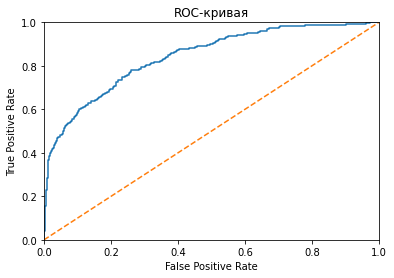

Accuracy модели равна 0.8185816382627817
Полнота модели равна 0.6199460916442049
Точность модели равна 0.548926014319809
F1 модели равна 0.5822784810126582
AUC-ROC модели равна 0.8423869339250347



,disbalance,model,accuracy,recall,precision,F1,AUC-ROC
0,yes,LogisticRegression,0.816,0.245,0.623,0.352,0.774
1,yes,Simple DecisionTree,0.808,0.531,0.530,0.530,0.705
2,yes,HyperParametrs DecisionTree,0.854,0.466,0.718,0.565,0.818
3,yes,Simple RandomForest,0.859,0.447,0.765,0.565,0.834
4,yes,HyperParametrs RandomForest,0.865,0.439,0.811,0.570,0.843
5,Weighted,LogisticRegression,0.721,0.709,0.397,0.509,0.778
6,Weighted,Simple DecisionTree,0.799,0.501,0.507,0.504,0.688
7,Weighted,HyperParametrs DecisionTree,0.771,0.677,0.459,0.547,0.827
8,Weighted,Simple RandomForest,0.855,0.420,0.765,0.543,0.837
9,Weighted,HyperParametrs RandomForest,0.842,0.609,0.612,0.611,0.847


Wall time: 712 ms


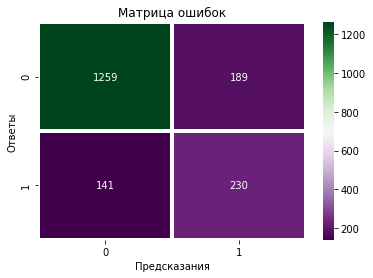

In [44]:
%%time
rf_res_2 = RandomForestClassifier(random_state=12345, criterion='gini', max_depth=10, min_samples_leaf=1,
                                min_samples_split=2, n_estimators=50) 
rf_res_2.fit(features_train_ord_up, target_train_ord_up)

roc_plot(rf_res_2, features_valid_ord, target_valid_ord)
metrics(rf_res_2, features_valid_ord, target_valid_ord)
model_res('UpSampling', 'HyperParametrs RandomForest', rf_res_2, features_valid_ord, target_valid_ord)

Применение метода UpSampling не дало существенного результата и для модели случайного леса с настроенными гиперпараметрами.
Лидером чарта все еще остается случайный лес с гиперпараметрами с взвешенными классами.

### 5.3 Уменьшение выборки

In [45]:
# подготовим функцию для уменьшения выборки
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [46]:
# проведем уменьшение обеих выборок, как ohe, так и ord
fraction = 0.25
features_train_ord_down, target_train_ord_down = downsample(features_train_ord, target_train_ord, fraction)
features_train_ohe_down, target_train_ohe_down = downsample(features_train_ohe, target_train_ohe, fraction)
print(features_train_ord_down.shape)
print(features_train_ohe_down.shape)
print(target_train_ord_down.value_counts())
print(target_train_ohe_down.value_counts())

(2198, 10)
(2198, 11)
1    1112
0    1086
Name: Exited, dtype: int64
1    1112
0    1086
Name: Exited, dtype: int64


Классы уравновешены, переходим к построению моделей.

#### 5.3.1 Логистическая регрессия

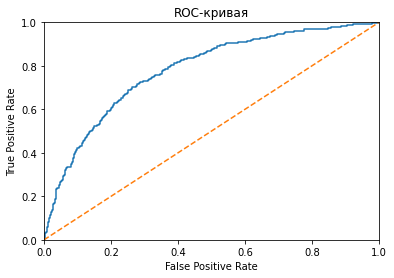

Accuracy модели равна 0.71412864211105
Полнота модели равна 0.7277628032345014
Точность модели равна 0.3918722786647315
F1 модели равна 0.509433962264151
AUC-ROC модели равна 0.7794988161010261



,disbalance,model,accuracy,recall,precision,F1,AUC-ROC
0,yes,LogisticRegression,0.816,0.245,0.623,0.352,0.774
1,yes,Simple DecisionTree,0.808,0.531,0.530,0.530,0.705
2,yes,HyperParametrs DecisionTree,0.854,0.466,0.718,0.565,0.818
3,yes,Simple RandomForest,0.859,0.447,0.765,0.565,0.834
4,yes,HyperParametrs RandomForest,0.865,0.439,0.811,0.570,0.843
5,Weighted,LogisticRegression,0.721,0.709,0.397,0.509,0.778
6,Weighted,Simple DecisionTree,0.799,0.501,0.507,0.504,0.688
7,Weighted,HyperParametrs DecisionTree,0.771,0.677,0.459,0.547,0.827
8,Weighted,Simple RandomForest,0.855,0.420,0.765,0.543,0.837
9,Weighted,HyperParametrs RandomForest,0.842,0.609,0.612,0.611,0.847


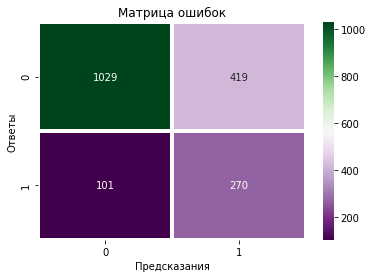

In [47]:
lr_3 = LogisticRegression(random_state=12345, solver='liblinear')
lr_3.fit(features_train_ohe_down, target_train_ohe_down)

roc_plot(lr_3, features_valid_ohe, target_valid_ohe)
metrics(lr_3, features_valid_ohe, target_valid_ohe)
model_res('DownSampling', 'LogisticRegression', lr_3, features_valid_ohe, target_valid_ohe)

Применение метода DownSampling позволило получить наилучшие результаты среди логистических регрессий по метрикам recall, F1, AUC-ROC. Но так как целевая метрика не выполняется, модель не может быть принята к использованию.

#### 5.3.2 Решающее дерево

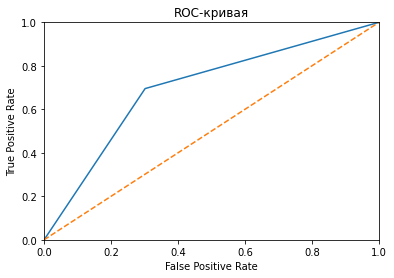

Accuracy модели равна 0.6976360637713029
Полнота модели равна 0.6954177897574124
Точность модели равна 0.3712230215827338
F1 модели равна 0.48405253283302063
AUC-ROC модели равна 0.6968111048234575



,disbalance,model,accuracy,recall,precision,F1,AUC-ROC
0,yes,LogisticRegression,0.816,0.245,0.623,0.352,0.774
1,yes,Simple DecisionTree,0.808,0.531,0.530,0.530,0.705
2,yes,HyperParametrs DecisionTree,0.854,0.466,0.718,0.565,0.818
3,yes,Simple RandomForest,0.859,0.447,0.765,0.565,0.834
4,yes,HyperParametrs RandomForest,0.865,0.439,0.811,0.570,0.843
5,Weighted,LogisticRegression,0.721,0.709,0.397,0.509,0.778
6,Weighted,Simple DecisionTree,0.799,0.501,0.507,0.504,0.688
7,Weighted,HyperParametrs DecisionTree,0.771,0.677,0.459,0.547,0.827
8,Weighted,Simple RandomForest,0.855,0.420,0.765,0.543,0.837
9,Weighted,HyperParametrs RandomForest,0.842,0.609,0.612,0.611,0.847


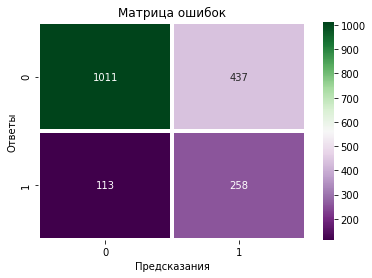

In [48]:
dt_3 = DecisionTreeClassifier(random_state=12345)
dt_3.fit(features_train_ord_down, target_train_ord_down)
roc_plot(dt_3, features_valid_ord, target_valid_ord)
metrics(dt_3, features_valid_ord, target_valid_ord)
model_res('DownSampling', 'Simple DecisionTree', dt_3, features_valid_ord, target_valid_ord)

Получили неплохие результаты по recall, но низкий результат precision занизил целевую метрику F1, поэтому модель также не может быть взята для применения. Попробуем подобрать гиперпараметры.

In [50]:
'''
%%time
tree = DecisionTreeClassifier(random_state=12345) # создаем модель с заданной глубиной дерева
tree.fit(features_train_ord_down, target_train_ord_down)

    
tree_params = {'max_depth': range(1,11),
              'criterion': ['gini', 'entropy'],
              'min_samples_leaf': range(1,20),
              'min_samples_split': range(2,40),
              }

tree_grid = GridSearchCV(tree, tree_params,
                         cv=5, verbose=3)

tree_grid.fit(features_train_ord_down, target_train_ord_down)
tree_grid.best_params_
'''

"\n%%time\ntree = DecisionTreeClassifier(random_state=12345) # создаем модель с заданной глубиной дерева\ntree.fit(features_train_ord_down, target_train_ord_down)\n\n    \ntree_params = {'max_depth': range(1,11),\n              'criterion': ['gini', 'entropy'],\n              'min_samples_leaf': range(1,20),\n              'min_samples_split': range(2,40),\n              }\n\ntree_grid = GridSearchCV(tree, tree_params,\n                         cv=5, verbose=3)\n\ntree_grid.fit(features_train_ord_down, target_train_ord_down)\ntree_grid.best_params_\n"

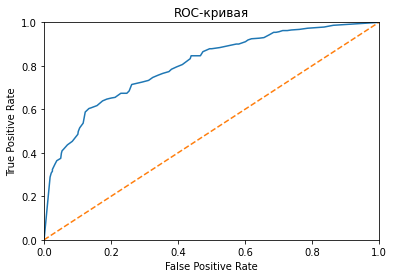

Accuracy модели равна 0.7333699835074217
Полнота модели равна 0.6846361185983828
Точность модели равна 0.40836012861736337
F1 модели равна 0.5115810674723061
AUC-ROC модели равна 0.802304693898825



,disbalance,model,accuracy,recall,precision,F1,AUC-ROC
0,yes,LogisticRegression,0.816,0.245,0.623,0.352,0.774
1,yes,Simple DecisionTree,0.808,0.531,0.530,0.530,0.705
2,yes,HyperParametrs DecisionTree,0.854,0.466,0.718,0.565,0.818
3,yes,Simple RandomForest,0.859,0.447,0.765,0.565,0.834
4,yes,HyperParametrs RandomForest,0.865,0.439,0.811,0.570,0.843
5,Weighted,LogisticRegression,0.721,0.709,0.397,0.509,0.778
6,Weighted,Simple DecisionTree,0.799,0.501,0.507,0.504,0.688
7,Weighted,HyperParametrs DecisionTree,0.771,0.677,0.459,0.547,0.827
8,Weighted,Simple RandomForest,0.855,0.420,0.765,0.543,0.837
9,Weighted,HyperParametrs RandomForest,0.842,0.609,0.612,0.611,0.847


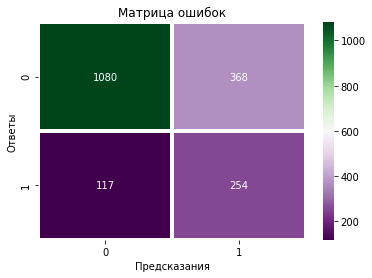

In [49]:
dt_res_3 = DecisionTreeClassifier(random_state=12345, criterion='gini', max_depth=9, 
                                  min_samples_leaf=12, min_samples_split=29)
dt_res_3.fit(features_train_ord_down, target_train_ord_down)

roc_plot(dt_res_3, features_valid_ord, target_valid_ord)
metrics(dt_res_3, features_valid_ord, target_valid_ord)
model_res('DownSampling', 'HyperParametrs DecisionTree', dt_res_3, features_valid_ord, target_valid_ord)

С подобранными параметрами результат стал значительно лучше - обе метрики (F1 и ROC) увеличились. Но т.к. значение F1 не достигает целевого, модель не может быть принята к использованию.

#### 5.3.3 Случайный лес

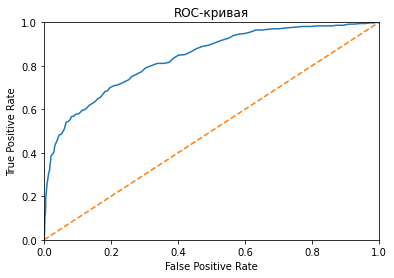

Accuracy модели равна 0.7740516767454645
Полнота модели равна 0.7088948787061995
Точность модели равна 0.46466431095406363
F1 модели равна 0.56136606189968
AUC-ROC модели равна 0.8360244076782177



,disbalance,model,accuracy,recall,precision,F1,AUC-ROC
0,yes,LogisticRegression,0.816,0.245,0.623,0.352,0.774
1,yes,Simple DecisionTree,0.808,0.531,0.530,0.530,0.705
2,yes,HyperParametrs DecisionTree,0.854,0.466,0.718,0.565,0.818
3,yes,Simple RandomForest,0.859,0.447,0.765,0.565,0.834
4,yes,HyperParametrs RandomForest,0.865,0.439,0.811,0.570,0.843
5,Weighted,LogisticRegression,0.721,0.709,0.397,0.509,0.778
6,Weighted,Simple DecisionTree,0.799,0.501,0.507,0.504,0.688
7,Weighted,HyperParametrs DecisionTree,0.771,0.677,0.459,0.547,0.827
8,Weighted,Simple RandomForest,0.855,0.420,0.765,0.543,0.837
9,Weighted,HyperParametrs RandomForest,0.842,0.609,0.612,0.611,0.847


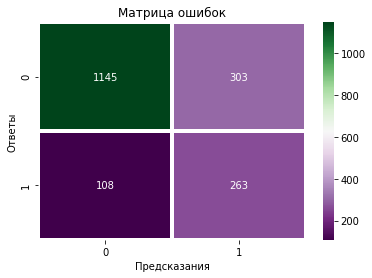

In [50]:
# создадим модель на основе случайного леса без регулировки гиперпараметров
rfc_3 = RandomForestClassifier(random_state=12345)
rfc_3.fit(features_train_ord_down, target_train_ord_down)

roc_plot(rfc_3, features_valid_ord, target_valid_ord)
metrics(rfc_3, features_valid_ord, target_valid_ord)
model_res('DownSampling', 'Simple RandomForest', rfc_3, features_valid_ord, target_valid_ord)

Попробуем подобрать оптимальные гиперпараметры.

In [53]:
'''
rf_3 = RandomForestClassifier(random_state=12345)
rf_3.fit(features_train_ord_down, target_train_ord_down)

forest_params = {'n_estimators': range(10, 51, 10),
                 'max_depth': range(1,11),               
              'criterion': ['gini', 'entropy'],
              'min_samples_leaf': range(1,11),
              'min_samples_split': range(2,11),
                'bootstrap':[True, False]}

forest_grid = GridSearchCV(rf_3, forest_params,
                         cv=5, verbose=3)

forest_grid.fit(features_train_ord_down, target_train_ord_down)
forest_grid.best_params_
'''

"\nrf_3 = RandomForestClassifier(random_state=12345)\nrf_3.fit(features_train_ord_down, target_train_ord_down)\n\nforest_params = {'n_estimators': range(10, 51, 10),\n                 'max_depth': range(1,11),               \n              'criterion': ['gini', 'entropy'],\n              'min_samples_leaf': range(1,11),\n              'min_samples_split': range(2,11),\n                'bootstrap':[True, False]}\n\nforest_grid = GridSearchCV(rf_3, forest_params,\n                         cv=5, verbose=3)\n\nforest_grid.fit(features_train_ord_down, target_train_ord_down)\nforest_grid.best_params_\n"

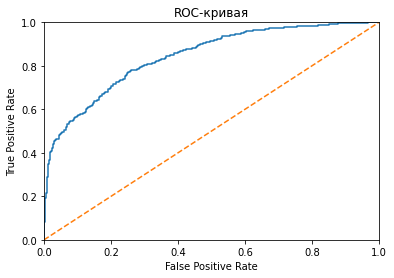

Accuracy модели равна 0.7811984606926883
Полнота модели равна 0.7035040431266847
Точность модели равна 0.47540983606557374
F1 модели равна 0.5673913043478261
AUC-ROC модели равна 0.8434647287456627



,disbalance,model,accuracy,recall,precision,F1,AUC-ROC
0,yes,LogisticRegression,0.816,0.245,0.623,0.352,0.774
1,yes,Simple DecisionTree,0.808,0.531,0.530,0.530,0.705
2,yes,HyperParametrs DecisionTree,0.854,0.466,0.718,0.565,0.818
3,yes,Simple RandomForest,0.859,0.447,0.765,0.565,0.834
4,yes,HyperParametrs RandomForest,0.865,0.439,0.811,0.570,0.843
5,Weighted,LogisticRegression,0.721,0.709,0.397,0.509,0.778
6,Weighted,Simple DecisionTree,0.799,0.501,0.507,0.504,0.688
7,Weighted,HyperParametrs DecisionTree,0.771,0.677,0.459,0.547,0.827
8,Weighted,Simple RandomForest,0.855,0.420,0.765,0.543,0.837
9,Weighted,HyperParametrs RandomForest,0.842,0.609,0.612,0.611,0.847


Wall time: 522 ms


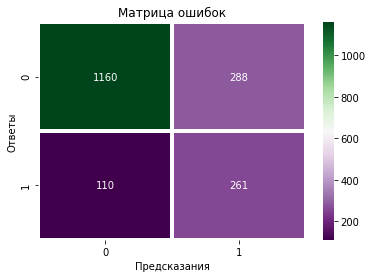

In [51]:
%%time
rf_res_3 = RandomForestClassifier(random_state=12345, criterion='entropy', max_depth=8, min_samples_leaf=2,
                                min_samples_split=5, n_estimators=50) 
rf_res_3.fit(features_train_ord_down, target_train_ord_down)

roc_plot(rf_res_3, features_valid_ord, target_valid_ord)
metrics(rf_res_3, features_valid_ord, target_valid_ord)
model_res('DownSampling', 'HyperParametrs RandomForest', rf_res_3, features_valid_ord, target_valid_ord)

Применение настроенных гиперпараметров позволило значительно увеличить метрики для случайного леса, но целевое значение F1 достигнуто не было. По итогу борьбы с дисбалансом лучшей моделью по метрикам F1 и AUC-ROC осталась модель случайного леса с настроенными гиперпараметрами и взвешенными классами. Проведем на ней финальное тестирование.

## 6 Тестирование модели

Для финального тестирования проведем объединение валидационной и тренировочной выборок и переобучим на них модель.

In [52]:
features_train_valid_ord_2 = pd.concat([features_train_ord] + [features_valid_ord])
target_train_valid_ord_2 = pd.concat([target_train_ord] + [target_valid_ord])
print(features_train_valid_ord_2.shape)
print(target_train_valid_ord_2.shape)

(7273, 10)
(7273,)


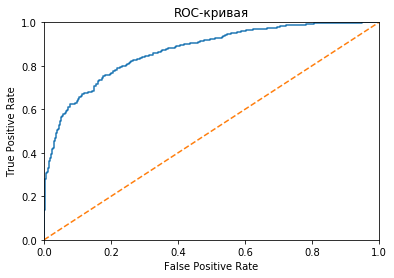

Accuracy модели равна 0.841034103410341
Полнота модели равна 0.6684636118598383
Точность модели равна 0.5990338164251208
F1 модели равна 0.6318471337579618
AUC-ROC модели равна 0.8685764952862787



,disbalance,model,accuracy,recall,precision,F1,AUC-ROC
0,yes,LogisticRegression,0.816,0.245,0.623,0.352,0.774
1,yes,Simple DecisionTree,0.808,0.531,0.530,0.530,0.705
2,yes,HyperParametrs DecisionTree,0.854,0.466,0.718,0.565,0.818
3,yes,Simple RandomForest,0.848,0.399,0.733,0.517,0.788
4,yes,HyperParametrs RandomForest,0.865,0.439,0.811,0.570,0.843
5,Weighted,LogisticRegression,0.721,0.709,0.397,0.509,0.778
6,Weighted,Simple DecisionTree,0.808,0.512,0.531,0.521,0.698
7,Weighted,HyperParametrs DecisionTree,0.771,0.677,0.459,0.547,0.827
8,Weighted,Simple RandomForest,0.848,0.364,0.771,0.495,0.801
9,Weighted,HyperParametrs RandomForest,0.839,0.598,0.608,0.603,0.848


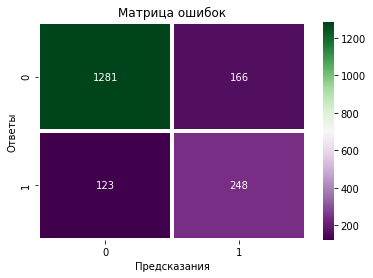

In [56]:
rf_res_final = RandomForestClassifier(random_state=12345, bootstrap=True, criterion='gini', max_depth=10, min_samples_leaf=1,
                                min_samples_split=8, n_estimators=30, class_weight='balanced') 
rf_res_final.fit(features_train_valid_ord_2, target_train_valid_ord_2) # переобучаем модель

roc_plot(rf_res_final, features_test_ord, target_test_ord)
metrics(rf_res_final, features_test_ord, target_test_ord)
model_res('Weighted', 'HyperParametrs RandomForest on the test', rf_res_final, features_test_ord, target_test_ord)

Получили самые наилучшие значения целевых метрик: F1 = 0.632, AUC-ROC = 0.869. Выбранная модель показала отличные результаты на тестовой выборке, удовлетворяет значению целевой метрики и выбирается в качестве финальной.

**Лучшая модель: Случайный лес с настроенными гиперпараметрами и со взвешенными классами.**